In [1]:
from pathlib import Path
import os

import torch
from dense_clip import DenseCLIP
import urllib

from PIL import Image

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T


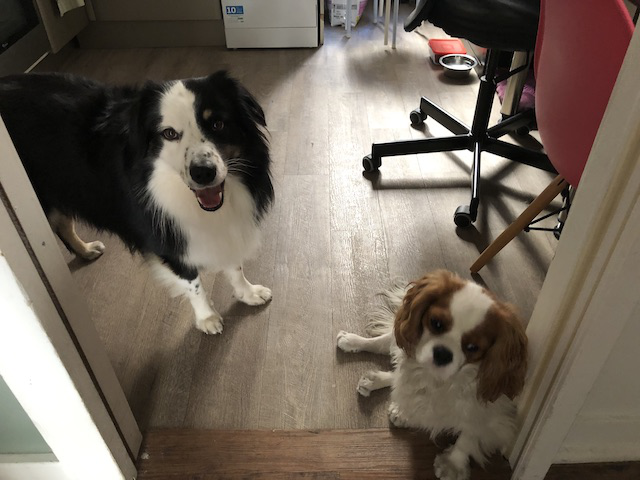

In [2]:
def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseCLIP('ViT-L/14@336px').to(device)
model.eval()


with torch.no_grad():
    feature = model(image)

/home/yuqun/miniconda3/envs/conceptfusion/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [12]:
image.size, 35 * 14, 46 * 14

((640, 480), 490, 644)

In [5]:
feature.shape

(1, 768, 35, 46)

In [10]:
from sklearn.cluster import KMeans
# feature_np = features.cpu()
H, W = 490, 644
ori_H, ori_W = 480, 640
upsampled_features = torch.tensor(feature)
upsampled_features = F.interpolate(upsampled_features, size = (H, W), mode = "bilinear", align_corners = False)
upsampled_features = T.CenterCrop((ori_H, ori_W)) (upsampled_features)
features_np = upsampled_features.cpu().permute(0, 2, 3, 1).reshape(ori_H * ori_W, -1).numpy()
kmeans = KMeans(n_clusters=5, random_state=0).fit(features_np)


/home/yuqun/miniconda3/envs/conceptfusion/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


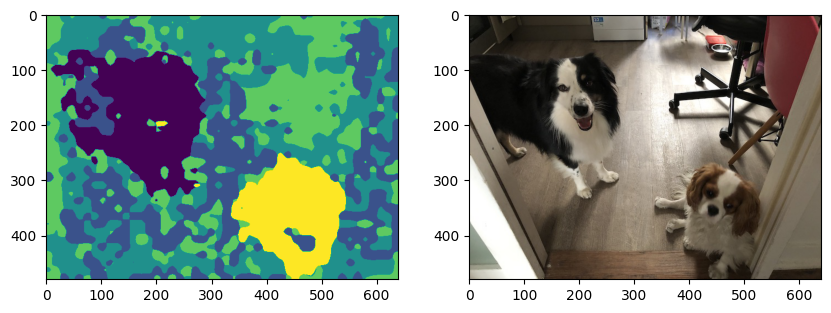

In [11]:
kmeans_features = kmeans.predict(features_np).reshape(ori_H, ori_W)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(kmeans_features)
plt.subplot(1, 2, 2)
plt.imshow(T.ToTensor()(image).permute(1,2,0))
plt.show()